In [1]:
# !pip install wn_affect
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from wn_affect import wn_affect 
import matplotlib.pyplot as plt

nltk.download('stopwords')
from nltk.corpus import stopwords
# use English stopwords
stops = set(stopwords.words("english"))

[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     由于目标计算机积极拒绝，无法连接。>


In [2]:
df = pd.read_csv('reviews4.csv')
df.head()

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,is_open,attributes,categories,yelping_since,fans,review_star,business_star,user_star
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2010-10-12 00:40:13,2,4.0,4.5,4.15
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2012-07-15 22:43:57,0,2.0,4.5,3.56
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2008-02-15 17:19:41,6,5.0,4.5,4.25
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,1,"{'RestaurantsReservations': 'False', 'Business...","Cajun/Creole, Restaurants, Breakfast & Brunch,...",2008-02-15 17:19:41,6,5.0,4.0,4.25
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,1,"{'GoodForKids': 'True', 'HasTV': 'True', 'Alco...","Restaurants, Pizza, Italian",2008-02-15 17:19:41,6,3.0,3.5,4.25


In [3]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

df['remove_lower_punct'] = df['text'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

display(df.head(10))

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,is_open,attributes,categories,yelping_since,fans,review_star,business_star,user_star,remove_lower_punct
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2010-10-12 00:40:13,2,4.0,4.5,4.15,the food is always great here the service from...
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2012-07-15 22:43:57,0,2.0,4.5,3.56,brasserie zero zero we were hoping for a ten b...
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2008-02-15 17:19:41,6,5.0,4.5,4.25,i absolutely love this restaurant ive been com...
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,1,"{'RestaurantsReservations': 'False', 'Business...","Cajun/Creole, Restaurants, Breakfast & Brunch,...",2008-02-15 17:19:41,6,5.0,4.0,4.25,i love you luciles \r\n\r\ni love your chai be...
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,1,"{'GoodForKids': 'True', 'HasTV': 'True', 'Alco...","Restaurants, Pizza, Italian",2008-02-15 17:19:41,6,3.0,3.5,4.25,pasta jays what can i say you knocked my socks...
5,5,"Yep, I love this place. It definitely is one o...",YtNH18ZyNAQS8F96vZAgsQ,2014-02-22 00:32:43,e8LpS2oGD77rDbn1sjCq_g,1,32HQqHGHqcDnNteK835C-Q,0,0,881,1,"{'WiFi': ""u'free'"", 'Caters': 'True', 'HasTV':...","Restaurants, Food, Diners, Breakfast & Brunch,...",2008-02-15 17:19:41,6,4.0,4.0,4.25,yep i love this place it definitely is one of ...
6,6,I've been to the Buff probably close to two do...,1LMe5UqMS2ei_ubt46FbNA,2013-08-06 04:01:37,qsEJaadO5J-sxWXmPX0WzQ,2,32HQqHGHqcDnNteK835C-Q,2,3,1429,1,"{'HasTV': 'True', 'RestaurantsReservations': '...","Restaurants, Soup, American (Traditional), Bre...",2008-02-15 17:19:41,6,5.0,4.5,4.25,ive been to the buff probably close to two doz...
7,7,The food is great! One of my fav brunch spots...,8zehGz9jnxPqXtOc7KaJxA,2018-05-08 17:16:08,24rHI3jxOd-vaITbjlQvag,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2018-05-08 17:11:37,0,5.0,4.5,4.00,the food is great one of my fav brunch spots i...
8,8,Seriously good food! The dumplings are to die...,guTsOdWQ-YWUHSJ3ubk8PQ,2018-05-08 17:14:44,5QlpD17nASTMtTlhr9eXqw,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,516,1,"{'BikeParking': 'True', 'Alcohol': ""u'beer_and...","Restaurants, Chinese",2018-05-08 17:11:37,0,5.0,3.5,4.00,seriously good food the dumplings are to die f...
9,9,Everything here is SO GOOD!!! They even have a...,BDw_Is0lDvhwsSLQxy1Dkw,2018-05-08 17:17:24,nSiyHOu5R1xT7Iwo0GkNbQ,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,606,1,"{'RestaurantsAttire': ""u'casual'"", 'OutdoorSea...","Argentine, Restaurants",2018-05-08 17:11:37,0,5.0,4.5,4.00,everything here is so good they even have a fe...


In [4]:
################ sentence Segment: using word_tokenize from nltk
# create a list of the reviews from the 'Reviews' column
words = df['remove_lower_punct'].tolist()

# tokenise the words
from nltk.tokenize import word_tokenize  
word_tokens = []
for sentence in words:
    word_tokens.append(word_tokenize(sentence))#word_tokenize(sentence)output a list.

# create a new list with stop words removed
filtered_reviews = []
for review in word_tokens:
    filtered_reviews.append([w for w in review if not w in stops])#remove stop word from tokenised words
# add the tokens to the dataframe    
df['tokens'] = filtered_reviews
df.head()

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,is_open,attributes,categories,yelping_since,fans,review_star,business_star,user_star,remove_lower_punct,tokens
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2010-10-12 00:40:13,2,4.0,4.5,4.15,the food is always great here the service from...,"[food, always, great, service, manager, well, ..."
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2012-07-15 22:43:57,0,2.0,4.5,3.56,brasserie zero zero we were hoping for a ten b...,"[brasserie, zero, zero, hoping, ten, based, hi..."
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2008-02-15 17:19:41,6,5.0,4.5,4.25,i absolutely love this restaurant ive been com...,"[absolutely, love, restaurant, ive, coming, br..."
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,1,"{'RestaurantsReservations': 'False', 'Business...","Cajun/Creole, Restaurants, Breakfast & Brunch,...",2008-02-15 17:19:41,6,5.0,4.0,4.25,i love you luciles \r\n\r\ni love your chai be...,"[love, luciles, love, chai, beignets, especial..."
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,1,"{'GoodForKids': 'True', 'HasTV': 'True', 'Alco...","Restaurants, Pizza, Italian",2008-02-15 17:19:41,6,3.0,3.5,4.25,pasta jays what can i say you knocked my socks...,"[pasta, jays, say, knocked, socks, first, time..."


In [5]:
# nltk.download('wordnet')
# initiate nltk lemmatiser

wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['tokens'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(df.head(10))

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,...,attributes,categories,yelping_since,fans,review_star,business_star,user_star,remove_lower_punct,tokens,lemmatise
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2010-10-12 00:40:13,2,4.0,4.5,4.15,the food is always great here the service from...,"[food, always, great, service, manager, well, ...","[food, always, great, service, manager, well, ..."
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2012-07-15 22:43:57,0,2.0,4.5,3.56,brasserie zero zero we were hoping for a ten b...,"[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, zero, hoping, ten, based, hi..."
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2008-02-15 17:19:41,6,5.0,4.5,4.25,i absolutely love this restaurant ive been com...,"[absolutely, love, restaurant, ive, coming, br...","[absolutely, love, restaurant, ive, coming, br..."
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,...,"{'RestaurantsReservations': 'False', 'Business...","Cajun/Creole, Restaurants, Breakfast & Brunch,...",2008-02-15 17:19:41,6,5.0,4.0,4.25,i love you luciles \r\n\r\ni love your chai be...,"[love, luciles, love, chai, beignets, especial...","[love, luciles, love, chai, beignet, especiall..."
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,...,"{'GoodForKids': 'True', 'HasTV': 'True', 'Alco...","Restaurants, Pizza, Italian",2008-02-15 17:19:41,6,3.0,3.5,4.25,pasta jays what can i say you knocked my socks...,"[pasta, jays, say, knocked, socks, first, time...","[pasta, jay, say, knocked, sock, first, time, ..."
5,5,"Yep, I love this place. It definitely is one o...",YtNH18ZyNAQS8F96vZAgsQ,2014-02-22 00:32:43,e8LpS2oGD77rDbn1sjCq_g,1,32HQqHGHqcDnNteK835C-Q,0,0,881,...,"{'WiFi': ""u'free'"", 'Caters': 'True', 'HasTV':...","Restaurants, Food, Diners, Breakfast & Brunch,...",2008-02-15 17:19:41,6,4.0,4.0,4.25,yep i love this place it definitely is one of ...,"[yep, love, place, definitely, one, favorite, ...","[yep, love, place, definitely, one, favorite, ..."
6,6,I've been to the Buff probably close to two do...,1LMe5UqMS2ei_ubt46FbNA,2013-08-06 04:01:37,qsEJaadO5J-sxWXmPX0WzQ,2,32HQqHGHqcDnNteK835C-Q,2,3,1429,...,"{'HasTV': 'True', 'RestaurantsReservations': '...","Restaurants, Soup, American (Traditional), Bre...",2008-02-15 17:19:41,6,5.0,4.5,4.25,ive been to the buff probably close to two doz...,"[ive, buff, probably, close, two, dozen, times...","[ive, buff, probably, close, two, dozen, time,..."
7,7,The food is great! One of my fav brunch spots...,8zehGz9jnxPqXtOc7KaJxA,2018-05-08 17:16:08,24rHI3jxOd-vaITbjlQvag,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,977,...,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, French",2018-05-08 17:11:37,0,5.0,4.5,4.00,the food is great one of my fav brunch spots i...,"[food, great, one, fav, brunch, spots, town, s...","[food, great, one, fav, brunch, spot, town, se..."
8,8,Seriously good food! The dumplings are to die...,guTsOdWQ-YWUHSJ3ubk8PQ,2018-05-08 17:14:44,5QlpD17nASTMtTlhr9eXqw,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,516,...,"{'BikeParking': 'True', 'Alcohol': ""u'beer_and...","Restaurants, Chinese",2018-05-08 17:11:37,0,5.0,3.5,4.00,seriously good food the dumplings are to die f...,"[seriously, good

In [6]:
#POS_TAGGING
from nltk import pos_tag
tags=[]
for lemma in df['lemmatise']:
    is_noun = lambda pos: (pos[:2] == 'NN'or pos[:2] == 'NNP'or pos[:2] == 'NNPS' or pos[:2] == 'NNS')
    nouns = [word for (word, pos) in nltk.pos_tag(lemma) if is_noun(pos)] 
    tags.append(nouns)
#     tags.append(pos_tag(words))  # POS tag the first review
df["pos"]=tags
df.head()

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,...,categories,yelping_since,fans,review_star,business_star,user_star,remove_lower_punct,tokens,lemmatise,pos
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,...,"Restaurants, French",2010-10-12 00:40:13,2,4.0,4.5,4.15,the food is always great here the service from...,"[food, always, great, service, manager, well, ...","[food, always, great, service, manager, well, ...","[food, service, manager, staff, draw, super, l..."
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,...,"Restaurants, French",2012-07-15 22:43:57,0,2.0,4.5,3.56,brasserie zero zero we were hoping for a ten b...,"[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, ten, quality, food, start, b..."
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,...,"Restaurants, French",2008-02-15 17:19:41,6,5.0,4.5,4.25,i absolutely love this restaurant ive been com...,"[absolutely, love, restaurant, ive, coming, br...","[absolutely, love, restaurant, ive, coming, br...","[restaurant, year, chance, visit, brunch, lunc..."
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,...,"Cajun/Creole, Restaurants, Breakfast & Brunch,...",2008-02-15 17:19:41,6,5.0,4.0,4.25,i love you luciles \r\n\r\ni love your chai be...,"[love, luciles, love, chai, beignets, especial...","[love, luciles, love, chai, beignet, especiall...","[love, luciles, beignet, jennifer, egg, menu, ..."
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,...,"Restaurants, Pizza, Italian",2008-02-15 17:19:41,6,3.0,3.5,4.25,pasta jays what can i say you knocked my socks...,"[pasta, jays, say, knocked, socks, first, time...","[pasta, jay, say, knocked, sock, first, time, ...","[pasta, jay, sock, time, everyone, pesto, crea..."


In [7]:
# put the lemmas back together as text
import string
rejoin = []
for review in df.lemmatise:
    x = ",".join(review) # join the word back together using ',' function from: https://www.runoob.com/python/att-string-join.html
    x = x.replace(",", " ") # replace commas with spaces
    # remove punctuation from the reviews using the string package
    rejoin.append(x.translate(str.maketrans('', '', string.punctuation)))

# add the reformed text to the data frame    
df['filtered_review'] = rejoin
df.head()

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,...,yelping_since,fans,review_star,business_star,user_star,remove_lower_punct,tokens,lemmatise,pos,filtered_review
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,...,2010-10-12 00:40:13,2,4.0,4.5,4.15,the food is always great here the service from...,"[food, always, great, service, manager, well, ...","[food, always, great, service, manager, well, ...","[food, service, manager, staff, draw, super, l...",food always great service manager well staff s...
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,...,2012-07-15 22:43:57,0,2.0,4.5,3.56,brasserie zero zero we were hoping for a ten b...,"[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, ten, quality, food, start, b...",brasserie zero zero hoping ten based highly re...
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,...,2008-02-15 17:19:41,6,5.0,4.5,4.25,i absolutely love this restaurant ive been com...,"[absolutely, love, restaurant, ive, coming, br...","[absolutely, love, restaurant, ive, coming, br...","[restaurant, year, chance, visit, brunch, lunc...",absolutely love restaurant ive coming brasseri...
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,...,2008-02-15 17:19:41,6,5.0,4.0,4.25,i love you luciles \r\n\r\ni love your chai be...,"[love, luciles, love, chai, beignets, especial...","[love, luciles, love, chai, beignet, especiall...","[love, luciles, beignet, jennifer, egg, menu, ...",love luciles love chai beignet especially egg ...
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,...,2008-02-15 17:19:41,6,3.0,3.5,4.25,pasta jays what can i say you knocked my socks...,"[pasta, jays, say, knocked, socks, first, time...","[pasta, jay, say, knocked, sock, first, time, ...","[pasta, jay, sock, time, everyone, pesto, crea...",pasta jay say knocked sock first time ever din...


In [8]:
# put the nouns back together as text
import string
rejoin = []
for review in df.pos:
    x = ",".join(review) # join the word back together using ',' function from: https://www.runoob.com/python/att-string-join.html
    x = x.replace(",", " ") # replace commas with spaces
    # remove punctuation from the reviews using the string package
    rejoin.append(x.translate(str.maketrans('', '', string.punctuation)))

# add the reformed text to the data frame    
df['pos_review'] = rejoin
df.head()

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,...,fans,review_star,business_star,user_star,remove_lower_punct,tokens,lemmatise,pos,filtered_review,pos_review
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,...,2,4.0,4.5,4.15,the food is always great here the service from...,"[food, always, great, service, manager, well, ...","[food, always, great, service, manager, well, ...","[food, service, manager, staff, draw, super, l...",food always great service manager well staff s...,food service manager staff draw super loud sna...
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,...,0,2.0,4.5,3.56,brasserie zero zero we were hoping for a ten b...,"[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, ten, quality, food, start, b...",brasserie zero zero hoping ten based highly re...,brasserie zero ten quality food start bitter s...
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,...,6,5.0,4.5,4.25,i absolutely love this restaurant ive been com...,"[absolutely, love, restaurant, ive, coming, br...","[absolutely, love, restaurant, ive, coming, br...","[restaurant, year, chance, visit, brunch, lunc...",absolutely love restaurant ive coming brasseri...,restaurant year chance visit brunch lunch dinn...
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,...,6,5.0,4.0,4.25,i love you luciles \r\n\r\ni love your chai be...,"[love, luciles, love, chai, beignets, especial...","[love, luciles, love, chai, beignet, especiall...","[love, luciles, beignet, jennifer, egg, menu, ...",love luciles love chai beignet especially egg ...,love luciles beignet jennifer egg menu thats m...
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,...,6,3.0,3.5,4.25,pasta jays what can i say you knocked my socks...,"[pasta, jays, say, knocked, socks, first, time...","[pasta, jay, say, knocked, sock, first, time, ...","[pasta, jay, sock, time, everyone, pesto, crea...",pasta jay say knocked sock first time ever din...,pasta jay sock time everyone pesto cream dayum...


# bag-of-words

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# set vectorizer - CountVectorizer for word counts and TfidfVectorizer for TF-IDF
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()
# create an array of word counts / TF-IDF scores
doc_vec = vectorizer.fit_transform(df.pos_review)#get压缩行稀疏矩阵<class 'scipy.sparse.csr.csr_matrix'>  
# print(type(doc_vec),doc_vec,doc_vec.toarray())#toarray() convert matrix into array(数组)
# convert this to a dataframe
print(doc_vec)
df2 = pd.DataFrame(doc_vec.toarray(), columns=vectorizer.get_feature_names())
# set a threshold to drop infrequent word
threshold = 0.1

# drop words based on the threshold
df2 = df2.drop(df2.mean()[df2.mean() < threshold].index.values, axis=1)

# join the two datasets together
# df = df.join(df2, how='left')
df2.head()

  (0, 4669)	1
  (0, 10367)	1
  (0, 7128)	1
  (0, 11010)	1
  (0, 3772)	1
  (0, 11295)	1
  (0, 6958)	1
  (0, 10691)	1
  (0, 8496)	1
  (0, 11407)	1
  (1, 4669)	1
  (1, 10367)	1
  (1, 1410)	1
  (1, 12968)	1
  (1, 11616)	1
  (1, 9309)	1
  (1, 11047)	1
  (1, 1112)	1
  (1, 10157)	2
  (1, 1689)	1
  (1, 4965)	1
  (1, 8958)	1
  (1, 541)	2
  (1, 10581)	1
  (1, 2292)	2
  :	:
  (16300, 3147)	2
  (16300, 10776)	1
  (16300, 2026)	1
  (16300, 12775)	1
  (16300, 9167)	1
  (16300, 2796)	1
  (16300, 6225)	1
  (16300, 3578)	1
  (16300, 7423)	1
  (16300, 10482)	1
  (16300, 242)	3
  (16300, 8986)	1
  (16300, 8710)	1
  (16300, 10438)	1
  (16300, 598)	1
  (16300, 2394)	1
  (16300, 5174)	1
  (16300, 9571)	1
  (16300, 241)	1
  (16300, 3582)	1
  (16300, 313)	1
  (16300, 9814)	1
  (16300, 1805)	1
  (16300, 6789)	1
  (16300, 6073)	1


# topic modelling

In [55]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 5, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(doc_vec)

# column names

topic_names = [ str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,...,tokens,lemmatise,pos,pos_review,1,2,3,4,5,Dominant_topic
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,...,"[food, always, great, service, manager, well, ...","[food, always, great, service, manager, well, ...","[food, service, manager, staff, draw, super, l...",food service manager staff draw super loud sna...,0.02,0.66,0.02,0.28,0.02,2
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,...,"[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, zero, hoping, ten, based, hi...","[brasserie, zero, ten, quality, food, start, b...",brasserie zero ten quality food start bitter s...,0.54,0.10,0.01,0.01,0.34,1
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,...,"[absolutely, love, restaurant, ive, coming, br...","[absolutely, love, restaurant, ive, coming, br...","[restaurant, year, chance, visit, brunch, lunc...",restaurant year chance visit brunch lunch dinn...,0.66,0.01,0.20,0.12,0.01,1
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,...,"[love, luciles, love, chai, beignets, especial...","[love, luciles, love, chai, beignet, especiall...","[love, luciles, beignet, jennifer, egg, menu, ...",love luciles beignet jennifer egg menu thats m...,0.01,0.01,0.95,0.01,0.01,3
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,...,"[pasta, jays, say, knocked, socks, first, time...","[pasta, jay, say, knocked, sock, first, time, ...","[pasta, jay, sock, time, everyone, pesto, crea...",pasta jay sock time everyone pesto cream dayum...,0.65,0.22,0.01,0.01,0.12,1
5,5,"Yep, I love this place. It definitely is one o...",YtNH18ZyNAQS8F96vZAgsQ,2014-02-22 00:32:43,e8LpS2oGD77rDbn1sjCq_g,1,32HQqHGHqcDnNteK835C-Q,0,0,881,...,"[yep, love, place, definitely, one, favorite, ...","[yep, love, place, definitely, one, favorite, ...","[yep, place, brunch, spot, boulder, wait, hint...",yep place brunch spot boulder wait hint closin...,0.01,0.01,0.97,0.01,0.01,3
6,6,I've been to the Buff probably close to two do...,1LMe5UqMS2ei_ubt46FbNA,2013-08-06 04:01:37,qsEJaadO5J-sxWXmPX0WzQ,2,32HQqHGHqcDnNteK835C-Q,2,3,1429,...,"[ive, buff, probably, close, two, dozen, times...","[ive, buff, probably, close, two, dozen, time,...","[buff, dozen, time, couple, year, love, front,...",buff dozen time couple year love front door dr...,0.00,0.00,0.98,0.00,0.00,3
7,7,The food is great! One of my fav brunch spots...,8zehGz9jnxPqXtOc7KaJxA,2018-05-08 17:16:08,24rHI3jxOd-vaITbjlQvag,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,977,...,"[food, great, one, fav, brunch, spots, town, s...","[food, great, one, fav, brunch, spot, town, se...","[food, fav, brunch, spot, town, service, envir...",food fav brunch spot town service environment ...,0.50,0.02,0.45,0.02,0.02,1
8,8,Seriously good food! The dumplings are to die...,guTsOdWQ-YWUHSJ3ubk8PQ,2018-05-08 17:14:44,5QlpD17nASTMtTlhr9eXqw,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,516,...,"[seriously, good, food, dumplings, die, everyt...","[seriously, good, food, dumpling, die, everyth...","[food, die, everything]",food die everything,0.79,0.05,0.05,0.05,0.05,1
9,9,Everything here is SO GOOD!!! They even have a...,BDw_Is0lDvhwsSLQxy1Dkw,2018-05-08 17:17:24,nSiyHOu5R1xT7Iwo0GkNbQ,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,606,...,"[everything, good, even, veg, gf, options, ive...","[everything, good, even, veg, gf, option, ive,...","[everything, option, anything, rincon, argenti...",everything option anything rincon argentino didnt,0.03,0.03,0.45,0.03,0.46,5


In [56]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
a1,2,1.181747
a2,4,1.195845
aaahs,1,1.198071
aaron,2,2.165965
ab,2,1.199995
...,...,...
zuppa,1,1.199632
zvlnviut4pcdppkrta,1,1.199995
étouffée,3,3.199143
ótima,1,1.199836


In [57]:

all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

#     tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)


,Dominant_topic,topic_name
0,2,[food]
1,4,[beer]
2,1,[hour]
3,3,[breakfast]
4,5,[flavor]


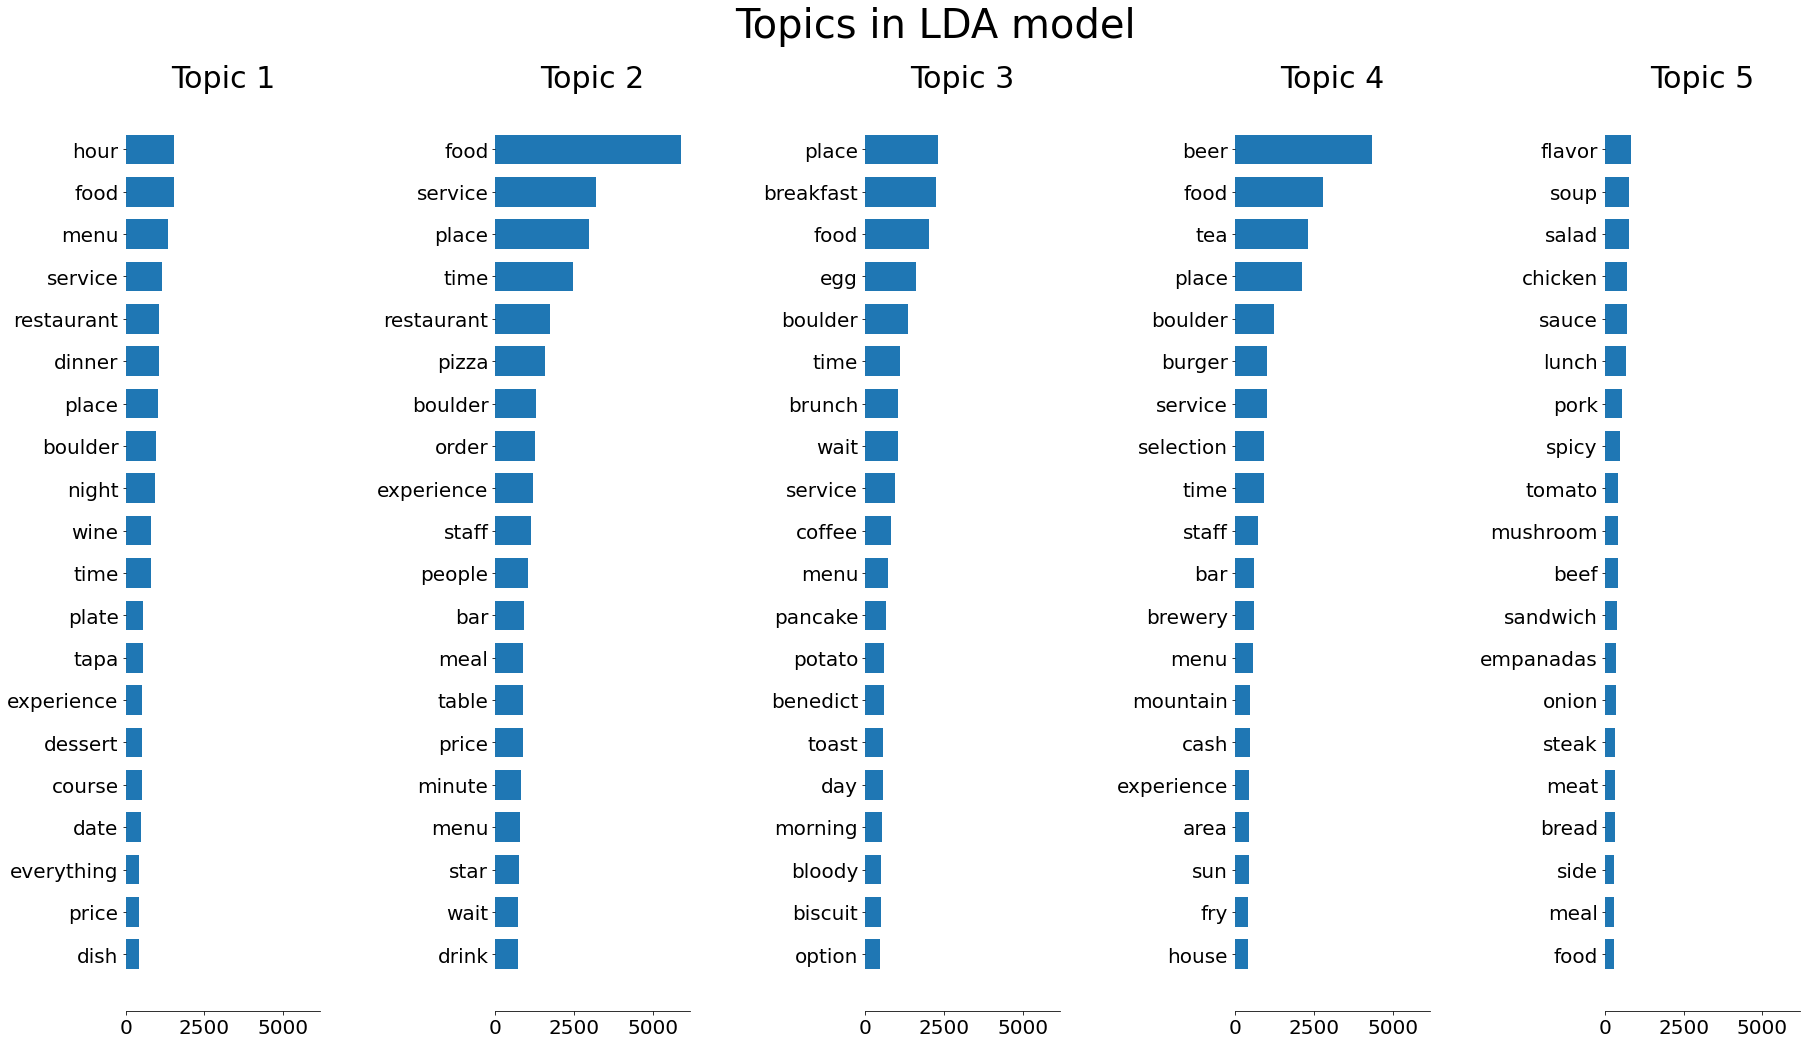

In [58]:
# latent Dirichlet allocation on the reviews data

# on first time run
# !pip install --user scikit-learn
# use the dataframe we made earlier!!!!

%matplotlib inline
import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation as LDA

# max_words = 500 # use only the top 500 words
# k = 5 # set number of topics as 10
n_top_words = 20 # print the top 20 words for each topic

# helper function to plot topics
# see Grisel et al. 
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1,5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
# # vectorise the data into word counts
# tf_vectorizer = CountVectorizer(max_features=max_words, stop_words='english')
# tf = tf_vectorizer.fit_transform(df['content'])

# fit LDA - we'll cover online learning later in the module
# lda = LDA(n_components=k, max_iter=5, learning_method='online')
# lda.fit(doc_vec)

# # get the list of words (feature names)
tf_feature_names = vectorizer.get_feature_names()

# # print the top words per topic
plot_top_words(lda_model, tf_feature_names, n_top_words, 'Topics in LDA model')

In [59]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(doc_vec))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(doc_vec))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -2564158.6805484765
Perplexity:  1092.418474882326
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 10, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [64]:
# !pip install --upgrade pip
# !pip install --upgrade jupyter notebook
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, doc_vec, vectorizer, mds='tsne')
panel

Script file 'D:\ProgramData\Anaconda3\Scripts\pip-script.py' is not present.


ModuleNotFoundError: No module named 'pyLDAvis'

# GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_vec)

KeyboardInterrupt: 

In [ ]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_vec))

# gridsearch and compare with plot

# sentiment analysis

In [65]:

# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(10))

,Unnamed: 0,text,business_id,date,review_id,cool,user_id,funny,useful,review_count,...,pos,pos_review,1,2,3,4,5,Dominant_topic,sentiment,sentiment score
0,0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,977,...,"[food, service, manager, staff, draw, super, l...",food service manager staff draw super loud sna...,0.02,0.66,0.02,0.28,0.02,2,Positive,0.9325
1,1,Brasserie zero zero... we were hoping for a te...,8zehGz9jnxPqXtOc7KaJxA,2018-08-04 20:52:32,eiAeuhR3kurAO8rAt_rhlg,0,7zEJt0NVl-lMiMwkCsvteg,0,0,977,...,"[brasserie, zero, ten, quality, food, start, b...",brasserie zero ten quality food start bitter s...,0.54,0.10,0.01,0.01,0.34,1,Positive,0.9022
2,2,I absolutely love this restaurant. I've been c...,8zehGz9jnxPqXtOc7KaJxA,2014-04-01 02:29:55,Ye8Uh3aBfGoEWgC7DEI8YA,1,32HQqHGHqcDnNteK835C-Q,0,0,977,...,"[restaurant, year, chance, visit, brunch, lunc...",restaurant year chance visit brunch lunch dinn...,0.66,0.01,0.20,0.12,0.01,1,Positive,0.9876
3,3,"I love you, Lucile's. \r\n\r\nI love your chai...",or-Kyw7kmNin1pWbu2RLJw,2011-07-28 23:27:24,CkDybuShgzu5QD1n5KvXjQ,1,32HQqHGHqcDnNteK835C-Q,1,1,628,...,"[love, luciles, beignet, jennifer, egg, menu, ...",love luciles beignet jennifer egg menu thats m...,0.01,0.01,0.95,0.01,0.01,3,Positive,0.9349
4,4,"Pasta Jays, what can I say? You knocked my soc...",eRlc-vfvnl9ai8RydqZfOw,2011-07-28 23:05:38,D2kXXOT9Fry0nK_UpI7HWg,1,32HQqHGHqcDnNteK835C-Q,0,2,516,...,"[pasta, jay, sock, time, everyone, pesto, crea...",pasta jay sock time everyone pesto cream dayum...,0.65,0.22,0.01,0.01,0.12,1,Negative,-0.3315
5,5,"Yep, I love this place. It definitely is one o...",YtNH18ZyNAQS8F96vZAgsQ,2014-02-22 00:32:43,e8LpS2oGD77rDbn1sjCq_g,1,32HQqHGHqcDnNteK835C-Q,0,0,881,...,"[yep, place, brunch, spot, boulder, wait, hint...",yep place brunch spot boulder wait hint closin...,0.01,0.01,0.97,0.01,0.01,3,Positive,0.9891
6,6,I've been to the Buff probably close to two do...,1LMe5UqMS2ei_ubt46FbNA,2013-08-06 04:01:37,qsEJaadO5J-sxWXmPX0WzQ,2,32HQqHGHqcDnNteK835C-Q,2,3,1429,...,"[buff, dozen, time, couple, year, love, front,...",buff dozen time couple year love front door dr...,0.00,0.00,0.98,0.00,0.00,3,Positive,0.9948
7,7,The food is great! One of my fav brunch spots...,8zehGz9jnxPqXtOc7KaJxA,2018-05-08 17:16:08,24rHI3jxOd-vaITbjlQvag,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,977,...,"[food, fav, brunch, spot, town, service, envir...",food fav brunch spot town service environment ...,0.50,0.02,0.45,0.02,0.02,1,Positive,0.9753
8,8,Seriously good food! The dumplings are to die...,guTsOdWQ-YWUHSJ3ubk8PQ,2018-05-08 17:14:44,5QlpD17nASTMtTlhr9eXqw,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,516,...,"[food, die, everything]",food die everything,0.79,0.05,0.05,0.05,0.05,1,Negative,-0.4588
9,9,Everything here is SO GOOD!!! They even have a...,BDw_Is0lDvhwsSLQxy1Dkw,2018-05-08 17:17:24,nSiyHOu5R1xT7Iwo0GkNbQ,0,0NB-ew_8OZ3Q4ysdKQEYrQ,0,0,606,...,"[everything, option, anything, rincon, argenti...",everything option anything rincon argentino didnt,0.03,0.03,0.45,0.03,0.46,5,Positive,0.3882


In [68]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

all_topics['Dominant_topic'] = all_topics['Dominant_topic'].astype(int)
results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['Dominant_topic', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='Dominant_topic', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('Dominant_topic', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
Dominant_topic,,,
1,65,17,2649
2,669,65,4437
3,145,34,3358
4,75,20,3469
5,69,11,1218


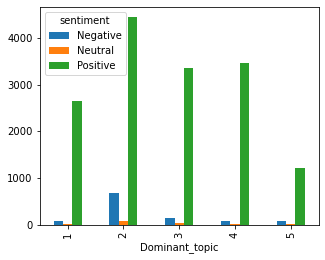

In [69]:
fig = graph_results.plot.bar(rot=90, figsize=(5,4))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

In [74]:
graph_results["negative_rate"]=[65/(2624+65+17),669/(669+65+4437),145/(145+34+3358),75/(75+20+3469),69/(69+11+1218)]

In [75]:
graph_results.head()

sentiment,Negative,Neutral,Positive,negative_rate
Dominant_topic,,,,
1,65,17,2649,0.024021
2,669,65,4437,0.129375
3,145,34,3358,0.040995
4,75,20,3469,0.021044
5,69,11,1218,0.053159


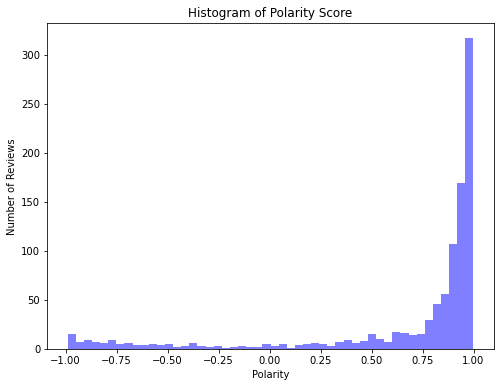

In [23]:
num_bins = 50
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df["sentiment score"], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

In [24]:
# import packages
from textblob import TextBlob

# calculate polarity and subjectivity
# df['Polarity'] = df['content'].apply(lambda content: TextBlob(str(content)).sentiment.polarity)
df['Subjectivity'] = df['remove_lower_punct'].apply(lambda content: TextBlob(str(content)).sentiment.subjectivity)
df.head()

,stars,text,business_id,date,review_id,cool,user_id,funny,useful,remove_lower_punct,...,pos_review,1,2,3,4,5,Dominant_topic,sentiment,sentiment score,Subjectivity
0,4.0,Apparently Prides Osteria had a rough summer a...,buF9druCkbuXLX526sGELQ,2014-10-11 03:34:02,lWC-xP3rd6obsecCYsGZRg,1,ak0TdVmGKo4pwqdJSTLwWw,1,3,apparently prides osteria had a rough summer a...,...,osteria summer room friday night blood kitchen...,0.00,0.99,0.00,0.00,0.00,2,Positive,0.9950,0.445892
1,4.0,This store is pretty good. Not as great as Wal...,RA4V8pr014UyUbDvI-LW2A,2015-07-03 20:38:25,8bFej1QE5LXp4O05qjGqXA,0,YoVfDbnISlW0f7abNQACIg,0,1,this store is pretty good not as great as walm...,...,store walmart milford target area get store st...,0.01,0.98,0.01,0.01,0.01,2,Positive,0.9961,0.592500
2,5.0,I called WVM on the recommendation of a couple...,_sS2LBIGNT5NQb6PD1Vtjw,2013-05-28 20:38:06,NDhkzczKjLshODbqDoNLSg,0,eC5evKn1TWDyHCyQAwguUw,0,0,i called wvm on the recommendation of a couple...,...,wvm recommendation couple friend thought job f...,0.01,0.01,0.97,0.01,0.01,3,Positive,0.9578,0.491058
3,2.0,I've stayed at many Marriott and Renaissance M...,0AzLzHfOJgL7ROwhdww2ew,2010-01-08 02:29:15,T5fAqjjFooT4V0OeZyuk1w,1,SFQ1jcnGguO0LYWnbbftAA,1,1,ive stayed at many marriott and renaissance ma...,...,marriott renaissance marriotts disappointment ...,0.01,0.96,0.01,0.01,0.01,2,Positive,0.4857,0.551263
4,4.0,The food is always great here. The service fro...,8zehGz9jnxPqXtOc7KaJxA,2011-07-28 18:05:01,sjm_uUcQVxab_EeLCqsYLg,0,0kA0PAJ8QFMeveQWHFqz2A,0,0,the food is always great here the service from...,...,food service manager staff draw super loud sna...,0.02,0.93,0.02,0.02,0.02,2,Positive,0.9325,0.647222


Text(0.5, 1.0, 'Distribution of Subjectivity Score')

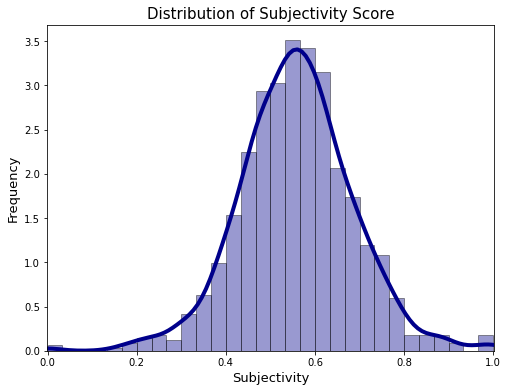

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# Density Plot and Histogram of subjectivity
plt.figure(figsize=(8,6))
sns.distplot(df['Subjectivity'], hist=True, kde=True,
bins=int(30), color = 'darkblue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)

In [76]:
df.to_csv('final.csv')

In [78]:
df.to_csv('final.csv')

In [95]:
# sort by polarity (low to high)
sorted_df = df.sort_values(by=['sentiment score'])
# print top 5 positive and negative
print("Most positive #5 reviews ")

print(sorted_df.text.tail())
# sf=sorted_df.text.tail()
# for i in sf:
#     print(i)

print("\n") # print line break
print("Most negative #5 reviews ")
print(sorted_df.text.head())
sf=sorted_df.text.head()
for i in sf:
    print(i)

Most positive #5 reviews 
10371    AMAZING!! One of the best veggie restaurants I...
4228     Despite the fact that I almost always read and...
7681     I'm sitting her writing this review as I am wi...
11707    Avery is my heaven on earth. Adam Avery: thank...
7901     ***Some of Frasca's food left me wanting more,...
Name: text, dtype: object


Most negative #5 reviews 
5726     This restaurant was unclean and the customer s...
13123    They may have cheap mimosas here, but the food...
7309     This place is so bad. I usually try not to rev...
7302     Came here for a snack today. Utterly disappoin...
12411    We still love the Buff and all of its deliciou...
Name: text, dtype: object
This restaurant was unclean and the customer service was terrible.  If I could give them no stars I would! Let me start off by saying my daughter and my husband were served dirty cups for our water and didn't notice until the host came to refill the cups. When I brought it to my servers attention he nod

In [86]:
# !pip install --upgrade pip
# !easy_install pip
!pip install wordcloud
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

content = "".join(i for i in df.pos_review)

wc = WordCloud(background_color = "black").generate(content)
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

ERROR: Exception:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip-21.2.4-py3.8.egg\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip-21.2.4-py3.8.egg\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip-21.2.4-py3.8.egg\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip-21.2.4-py3.8.egg\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip-21.2.4-py3.8.egg\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip-21.2.4-py3.

ModuleNotFoundError: No module named 'wordcloud'